# 03. Generating Sets of Chemicals with the ChemicalMixtureCreator class

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import numpy as np

In [3]:
import os
import sys
sys.path.append('../..')

In [4]:
import pylab as plt
%matplotlib inline

In [5]:
from vimms.Chemicals import ChemicalMixtureCreator

## Introduction

The `ChemicalMixtureCreator` offers the most simple method for creating chemical datasets for simulation allowing the generation of a dataset of chemicals in just a few lines of python.

The class requires several other classes to run:

- A class that can generate _formulas_
- A class that can generate RT and intensity for formulas
- A class that can generate chromatograms for formulas
- A class that can generate MS2 spectra for formulas

### `FormulaSampler`

An instance of a class extending `FormulaSampler` must be provided. This samples the chemicals that will appear. Note that `Formula` is abused here: in some cases the result is a chemical formula, but in others, just an m/z. Which it does has implications for the data generated (see below).  Currently, the following options are available:

- `DatabaseFormulaSampler`: samples formulas from a database provided. Code is given to generate from HMDB
- `UniformMZFormulaSampler`: samples _formulas_ (just masses) uniformly in an m/z range
- `PickEverythingFormulaSampler`: samples all formulas from a database
- `EvenMZFormulaSampler`: creates evenly spaced m/z, starting at 100Da, with 100 Da spacing. Mainly used for test cases.
- `MZMLFormulaSampler`: samples m/z values from a histogram of m/z taken from a user supplied mzML file

Examples of creating some of these objects

#### `DatabaseFormulaSampler`

In [6]:
from vimms.ChemicalSamplers import DatabaseFormulaSampler
from vimms.Common import load_obj

In [7]:
data_dir = os.path.abspath(os.path.join(os.getcwd(),'..','..','tests','fixtures'))
HMDB = os.path.join(data_dir,'hmdb_compounds.p')
hmdb = load_obj(HMDB)

2022-02-22 14:06:06.472 | DEBUG    | vimms.ChemicalSamplers:sample:73 - 73822 unique formulas in filtered database
2022-02-22 14:06:06.476 | DEBUG    | vimms.ChemicalSamplers:sample:79 - Sampled formulas


(array([ 59.,  72.,  83.,  55.,  63.,  50.,  91., 135., 210., 182.]),
 array([106.02660868, 193.30071191, 280.57481515, 367.84891838,
        455.12302161, 542.39712485, 629.67122808, 716.94533131,
        804.21943454, 891.49353778, 978.76764101]),
 <BarContainer object of 10 artists>)

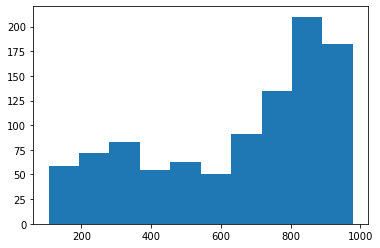

In [8]:
# create a database formula sampler that will sample from HMDB with m/z between 100 and 1000
df = DatabaseFormulaSampler(hmdb, min_mz=100, max_mz=1000)
samples = df.sample(1000)
mz_list = [s[0].mass for s in samples]
plt.hist(mz_list)

(array([ 96., 102.,  99., 106.,  98., 115.,  97.,  92.,  87., 108.]),
 array([100.35277837, 140.29636869, 180.23995902, 220.18354935,
        260.12713967, 300.07073   , 340.01432032, 379.95791065,
        419.90150097, 459.8450913 , 499.78868163]),
 <BarContainer object of 10 artists>)

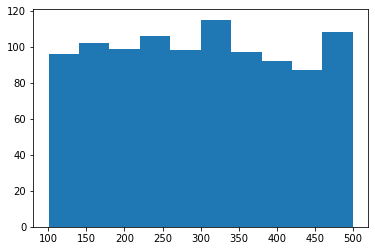

In [9]:
from vimms.ChemicalSamplers import UniformMZFormulaSampler
# create a formula sampler that samples masses uniformly between 100 and 500
df = UniformMZFormulaSampler(min_mz=100, max_mz=500)
samples = df.sample(1000)
mz_list = [s[0].mass for s in samples]
plt.hist(mz_list)

2022-02-22 14:06:06.902 | DEBUG    | mass_spec_utils.data_import.mzml:_load_file:166 - Loaded 364 scans


(array([ 93., 262., 125., 437.,  53.,  13.,   3.,  10.,   1.,   3.]),
 array([ 74.02336614, 131.63928006, 189.25519398, 246.8711079 ,
        304.48702182, 362.10293574, 419.71884966, 477.33476358,
        534.9506775 , 592.56659142, 650.18250534]),
 <BarContainer object of 10 artists>)

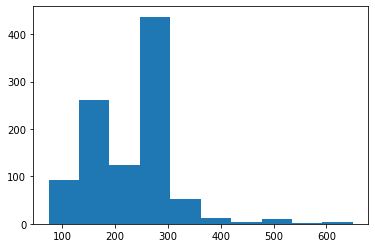

In [10]:
from vimms.ChemicalSamplers import MZMLFormulaSampler
MZML = os.path.join(data_dir, 'small_mzml.mzML')
df = MZMLFormulaSampler(MZML)
samples = df.sample(1000)
mz_list = [s[0].mass for s in samples]
plt.hist(mz_list)

### `RTAndIntensitySampler`

Passing an instance of this is optional. If nothing is passed, it defaults to `UniformRTAndIntensitySampler`

Available:

- `UniformRTAndIntensitySampler`: samples RT and intensity independently from uniform distributions (note that intensity is unifrom in log space)
- `MZMLRTandIntensitySampler`: samples RT and intensity independely from histograms produced from an mzML file

Examples:

#### `UniformRTAndIntensitySampler`

(array([666.,  94.,  59.,  42.,  28.,  35.,  26.,  24.,  16.,  10.]),
 array([7.41341489e+00, 8.16978154e+02, 1.62654289e+03, 2.43610763e+03,
        3.24567237e+03, 4.05523711e+03, 4.86480185e+03, 5.67436659e+03,
        6.48393133e+03, 7.29349606e+03, 8.10306080e+03]),
 <BarContainer object of 10 artists>)

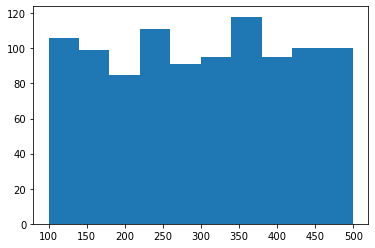

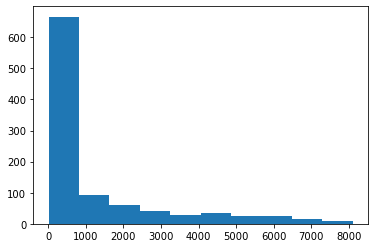

In [11]:
from vimms.ChemicalSamplers import UniformRTAndIntensitySampler
ri = UniformRTAndIntensitySampler(min_rt=100, max_rt=500, min_log_intensity=2, max_log_intensity=9)
rt_list = []
intensity_list = []
for i in range(1000):
    a,b = ri.sample(None) #argument is a formula, but is ignored at the moment
    rt_list.append(a)
    intensity_list.append(b)
plt.figure()
plt.hist(rt_list)
plt.figure()
plt.hist(intensity_list)

#### `MZMLRTandIntensitySampler`

2022-02-22 14:06:07.346 | DEBUG    | mass_spec_utils.data_import.mzml:_load_file:166 - Loaded 364 scans


(array([979.,   8.,   3.,   3.,   1.,   0.,   0.,   4.,   0.,   2.]),
 array([  15644.65964294,  815655.85954205, 1615667.05944115,
        2415678.25934026, 3215689.45923936, 4015700.65913847,
        4815711.85903757, 5615723.05893668, 6415734.25883578,
        7215745.45873489, 8015756.65863399]),
 <BarContainer object of 10 artists>)

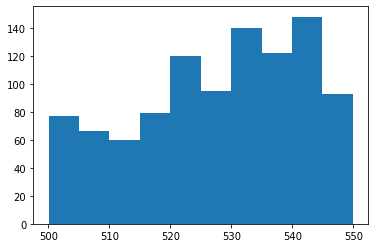

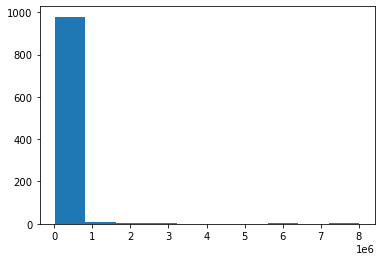

In [12]:
from vimms.ChemicalSamplers import MZMLRTandIntensitySampler
ri = MZMLRTandIntensitySampler(MZML)

rt_list = []
intensity_list = []

for i in range(1000):
    a,b = ri.sample(None) #argument is a formula, but is ignored at the moment
    rt_list.append(a)
    intensity_list.append(b)

plt.figure()
plt.hist(rt_list)
plt.figure()
plt.hist(intensity_list)

### `ChromatogramSampler`

This optional object defines where chromatograms should be sampled from for each formula. There are three options:

- `GaussianChromatogramSampler`: generates normal shape chromatographic peaks
- `ConstantChromoatogramSampler`: generates constant chromatographic (i.e. flat) peaks (mainly for testing)
- `MZMLChromatogramSampelr`: samples chromatograms from ROIs extracted from an mzML file

Note that in all cases, the `sample` method takes three arguments: a formula, an rt and an intensity. These are so that, in future we could condition the chromatogram finding on particular values of RT and intensity (e.g. high intensity = better peaks).

Examples:

#### `GaussianChomatogramSampler`

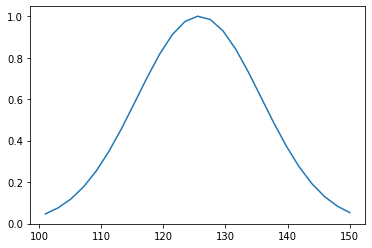

In [13]:
# grab a formula to use for example sampling
f_list = df.sample(1)
formula, name = f_list[0]
from vimms.ChemicalSamplers import GaussianChromatogramSampler
cs = GaussianChromatogramSampler(sigma=10)
example_rt = 100
example_intensity = 1e5
c = cs.sample(formula, example_rt, example_intensity)
rt_vals = np.linspace(50,150)
intensities = []
for r in rt_vals:
    intensities.append(c.get_relative_intensity(r - example_rt))
plt.plot(rt_vals, intensities)

#### `ConstantChromatogramSampler`

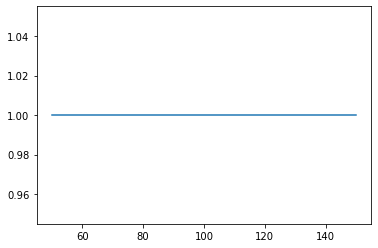

In [14]:
from vimms.ChemicalSamplers import ConstantChromatogramSampler
cs = ConstantChromatogramSampler()
example_rt = 100
example_intensity = 1e5
c = cs.sample(formula, example_rt, example_intensity)
rt_vals = np.linspace(50,150)
intensities = []
for r in rt_vals:
    intensities.append(c.get_relative_intensity(r - example_rt))
plt.plot(rt_vals, intensities)

#### `MZMLChromatogramSampler`

2022-02-22 14:06:11.505 | DEBUG    | vimms.ChemicalSamplers:_extract_rois:370 - Extracted 8119 good ROIs from /Users/joewandy/Work/git/vimms/tests/fixtures/small_mzml.mzML


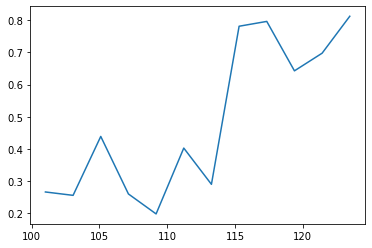

In [15]:
# note that if you want to set the parameters for the ROI extraction from the mzML, use the RioParams object
# e.g.
from vimms.Roi import RoiParams
roi_params = RoiParams(min_intensity=1000)
from vimms.ChemicalSamplers import MZMLChromatogramSampler
cs = MZMLChromatogramSampler(MZML, roi_params=roi_params)
c = cs.sample(formula, example_rt, example_intensity)
rt_vals = np.linspace(50,150)
intensities = []
for r in rt_vals:
    intensities.append(c.get_relative_intensity(r - example_rt))
plt.plot(rt_vals, intensities)

### MS2Sampler

This final class determines how chemicals will be assigned MS2 peaks. There are six options:

- `UniformMS2Sampler`: samples uniformly between a min mass and the mass of the formula
- `FixedMS2Sampler`: generates a fixed number of peaks, evenly spaced below the formula (mainly for testing)
- `CRPSMS2Sampler`: generates MS2 peaks using a Chinese Restaurant Process
- `MGFMS2Sampler`: generates MS2 spectra by sampling from those in an mgf file
- `ExactMatchMS2Sampler`: to be used in the case where objects in the MGF file share an ID with the database used for formula sampling
- `MZMLMS2Sampler`: samples MS2 spectra from an MS2 scan in an mzML file

In all cases, `sample` returns a list of masses, a list of intensties, and a *parent proportion* which is how much of the parents intensity gets transfered into the MS2 spectrum. The proportion is uniform between `min_proportion` and `max_proportion` which are passed to the constructors.

Examples:

In [16]:
def plot_spectrum(mz_list, intensity_list):
    plt.figure()
    for i,m in enumerate(mz_list):
        plt.plot([m,m],[0,intensity_list[i]])
class TempChemical:
    def __init__(self, mass):
        self.mass = mass

#### `UniformMS2Sampler`

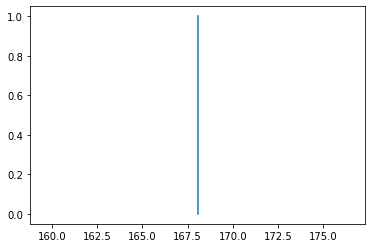

In [17]:
from vimms.ChemicalSamplers import UniformMS2Sampler
ms = UniformMS2Sampler(poiss_peak_mean=5) # number of fragments is decided by sample from poisson
tc = TempChemical(formula.mass)
a = ms.sample(tc)
mz_list = a[0]
intensity_list = a[1]
plot_spectrum(mz_list, intensity_list)

#### `CRPMS2Sampler`

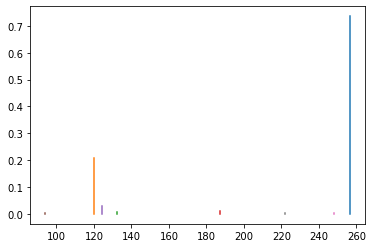

In [18]:
from vimms.ChemicalSamplers import CRPMS2Sampler
ms = CRPMS2Sampler(n_draws=500, alpha=1) # alpha and n_draws control the propery of the CRP
a = ms.sample(tc)
mz_list = a[0]
intensity_list = a[1]
plot_spectrum(mz_list, intensity_list)

#### `FixedMS2Sampler`

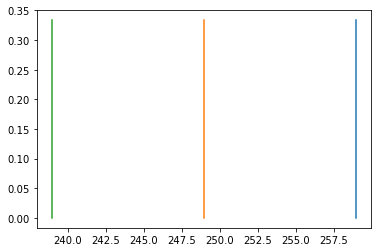

In [19]:
from vimms.ChemicalSamplers import FixedMS2Sampler
ms = FixedMS2Sampler(n_frags=3) # how many to make
a = ms.sample(tc)
mz_list = a[0]
intensity_list = a[1]
plot_spectrum(mz_list, intensity_list)

#### `MGFMS2Sampler`

2022-02-22 14:06:11.885 | DEBUG    | mass_spec_utils.library_matching.gnps:load_mgf:38 - Loaded 100 spectra
2022-02-22 14:06:11.892 | DEBUG    | mass_spec_utils.library_matching.gnps:load_mgf:38 - Loaded 200 spectra
2022-02-22 14:06:11.907 | DEBUG    | mass_spec_utils.library_matching.gnps:load_mgf:38 - Loaded 300 spectra
2022-02-22 14:06:11.962 | DEBUG    | mass_spec_utils.library_matching.gnps:load_mgf:38 - Loaded 400 spectra
2022-02-22 14:06:11.971 | DEBUG    | vimms.ChemicalSamplers:__init__:536 - Loaded 411 spectra from /Users/joewandy/Work/git/vimms/tests/fixtures/small_mgf.mgf


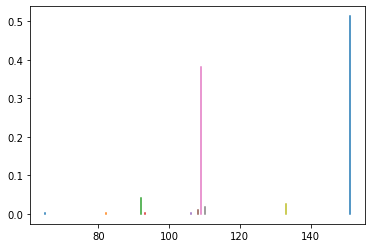

In [20]:
MGF = os.path.join(data_dir, 'small_mgf.mgf')
from vimms.ChemicalSamplers import MGFMS2Sampler
ms = MGFMS2Sampler(MGF)
a = ms.sample(tc)
mz_list = a[0]
intensity_list = a[1]
plot_spectrum(mz_list, intensity_list)

#### `MZMLMS2Sampler`

2022-02-22 14:06:12.179 | DEBUG    | mass_spec_utils.data_import.mzml:_load_file:166 - Loaded 364 scans
2022-02-22 14:06:12.188 | DEBUG    | vimms.ChemicalSamplers:_filter_scans:607 - 331 MS2 scansn remaining


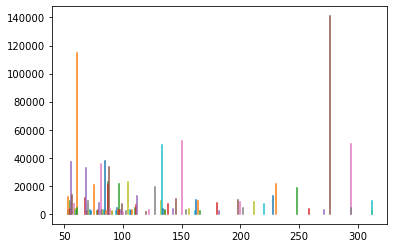

In [21]:
from vimms.ChemicalSamplers import MZMLMS2Sampler
ms = MZMLMS2Sampler(MZML)
a = ms.sample(tc)
mz_list = a[0]
intensity_list = a[1]
plot_spectrum(mz_list, intensity_list)

#### `ExactMatchMS2Sampler`

2022-02-22 14:06:12.324 | DEBUG    | mass_spec_utils.library_matching.gnps:load_mgf:38 - Loaded 100 spectra
2022-02-22 14:06:12.331 | DEBUG    | mass_spec_utils.library_matching.gnps:load_mgf:38 - Loaded 200 spectra
2022-02-22 14:06:12.346 | DEBUG    | mass_spec_utils.library_matching.gnps:load_mgf:38 - Loaded 300 spectra
2022-02-22 14:06:12.400 | DEBUG    | mass_spec_utils.library_matching.gnps:load_mgf:38 - Loaded 400 spectra
2022-02-22 14:06:12.409 | DEBUG    | vimms.ChemicalSamplers:__init__:536 - Loaded 411 spectra from /Users/joewandy/Work/git/vimms/tests/fixtures/small_mgf.mgf


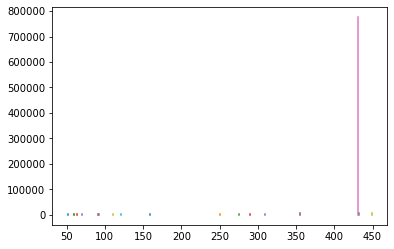

In [22]:
from vimms.ChemicalSamplers import ExactMatchMS2Sampler
# when formulas are sampled from a database, their accession is stored. We can cheat this as follows:
tc.database_accession = 'CCMSLIB00005435506'
# the MS2 sampler will then extract the spectrum that has the id_fiels set to this ID value
ms = ExactMatchMS2Sampler(MGF, id_field='SPECTRUMID')
a = ms.sample(tc)
mz_list = a[0]
intensity_list = a[1]
plot_spectrum(mz_list, intensity_list)

## Everything together - `ChemicalMixtureCreator`

The simplest use is to just pass a formula sampler and let the rest go to defaults:

In [23]:
from vimms.Chemicals import ChemicalMixtureCreator
df = DatabaseFormulaSampler(hmdb, min_mz=100, max_mz=1000)
cm = ChemicalMixtureCreator(df)
chemicals = cm.sample(100,2) # sample 100 chemicals up to MS2

2022-02-22 14:06:16.019 | DEBUG    | vimms.ChemicalSamplers:sample:73 - 73822 unique formulas in filtered database
2022-02-22 14:06:16.020 | DEBUG    | vimms.ChemicalSamplers:sample:79 - Sampled formulas
2022-02-22 14:06:16.089 | DEBUG    | vimms.Chemicals:sample:324 - Sampled rt and intensity values and chromatograms


If more tailoring is required, pass the different samplers as arguments. E.g. if you wanted a CRPMS2Sampler and MZMLChromatograms:

In [24]:
cm = ChemicalMixtureCreator(df, ms2_sampler=CRPMS2Sampler(n_draws=100, alpha=2), chromatogram_sampler=MZMLChromatogramSampler(MZML))
chemicals = cm.sample(100,2)

2022-02-22 14:06:18.150 | DEBUG    | vimms.ChemicalSamplers:_extract_rois:370 - Extracted 8119 good ROIs from /Users/joewandy/Work/git/vimms/tests/fixtures/small_mzml.mzML
2022-02-22 14:06:21.651 | DEBUG    | vimms.ChemicalSamplers:sample:73 - 73822 unique formulas in filtered database
2022-02-22 14:06:21.653 | DEBUG    | vimms.ChemicalSamplers:sample:79 - Sampled formulas
2022-02-22 14:06:21.668 | DEBUG    | vimms.Chemicals:sample:324 - Sampled rt and intensity values and chromatograms
